In [14]:
import sys
from pathlib import Path
import os

# Add parent directory to path
notebook_path = Path(os.getcwd())
sys.path.insert(0, str(notebook_path.parent))

from bot.data import client
from bot.rules import *
from bot.config.utils import read_tickers, read_config

tickers = read_tickers()

In [205]:
import pickle
from bot.data import load_ohlcv
from bot.rules.signal_filter import breakout, volume_breakout
from bot.rules.execution_filter import upper_donchian_breach
import pandas as pd

start_str = "1 year ago UTC"

signal_filters = [breakout, volume_breakout]
signal_timeframe = "30m"

execution_filters = [upper_donchian_breach]
execution_timeframe = "5m"

reload = False

datas_signal = {}
datas_execution = {}
if reload:
    for ticker in tickers[:23]:

        print(f"Processing {ticker}...")

        df_signal = load_ohlcv(ticker, signal_timeframe, start_str)
        df_execution = load_ohlcv(ticker, execution_timeframe, start_str)

        datas_signal[ticker] = df_signal
        datas_execution[ticker] = df_execution

    with open('test_data.pkl', 'wb') as f:
        pickle.dump((datas_signal, datas_execution), f)
else: 
    with open('test_data.pkl', 'rb') as f:
        datas_signal, datas_execution = pickle.load(f)




In [206]:
config = read_config()

for ticker, df in datas_signal.items():
    signals = {}
    scores = {}
    for filter in signal_filters:
        signals[filter.NAME], scores[filter.NAME+'_score'] = filter.vec(df, **{k:config[k] for k in filter.REQUIRES})
    df = pd.concat([df, pd.concat(signals, axis=1), pd.concat(scores, axis=1)], axis=1)
    df['atr'] = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=48)
    df = df.dropna(subset=['atr'])
    datas_signal[ticker] = df

for ticker, df in datas_execution.items():
    executions = {}
    scores = {}
    for filter in execution_filters:
        executions[filter.NAME], scores[filter.NAME+'_score'] = filter.vec(df, **{k:config[k] for k in filter.REQUIRES})
    df = pd.concat([df, pd.concat(executions, axis=1), pd.concat(scores, axis=1)], axis=1)
    datas_execution[ticker] = df

In [212]:
import talib as ta
import matplotlib.pyplot as plt

stats = {}

config = read_config()


signal_names = [filter.NAME for filter in signal_filters]
execution_names = [filter.NAME for filter in execution_filters]

starting_cash = 100

cash = starting_cash
values = {}
current_ticker = None

df_signal = datas_signal[tickers[0]]
df = datas_execution[tickers[0]]

for close_date in df.loc[df_signal.index.min(): df_signal.index.max()].index[10:]:
    
    for ticker, df in datas_execution.items():
        if current_ticker is not None and ticker != current_ticker:
            continue

        df_signal = datas_signal[ticker]

        # entry logic
        if (position == 0) & df_signal.loc[:close_date, signal_names].iloc[-1].all() & df.loc[close_date, execution_names].all():
            atr = df_signal.loc[:close_date, 'atr'].iloc[-1]
            position = cash / df.loc[close_date, 'Close']
            entry_price = df.loc[close_date, 'Close']
            initial_stop_loss = entry_price - atr
            cash = 0
            current_ticker = ticker

        # exit logic
        elif position > 0:
            stop_loss = max(initial_stop_loss, df_signal.loc[:close_date, 'Close'].iloc[-1] - (atr * config['min_loss_atr']))
            if df_signal.loc[close_date:, 'Close'].iloc[-1] <= stop_loss:
                cash = stop_loss * position
                position = 0
                current_ticker = None

        value = position * df.loc[close_date, 'Close'] + cash
        values[close_date] = value

    print(close_date, value)

2024-12-31 18:19:59.999000 100.0
2024-12-31 18:24:59.999000 100.0
2024-12-31 18:29:59.999000 100.0
2024-12-31 18:34:59.999000 100.0
2024-12-31 18:39:59.999000 100.0
2024-12-31 18:44:59.999000 100.0
2024-12-31 18:49:59.999000 100.0
2024-12-31 18:54:59.999000 100.0
2024-12-31 18:59:59.999000 100.0
2024-12-31 19:04:59.999000 100.0
2024-12-31 19:09:59.999000 100.0
2024-12-31 19:14:59.999000 100.0
2024-12-31 19:19:59.999000 100.0
2024-12-31 19:24:59.999000 100.0
2024-12-31 19:29:59.999000 100.0
2024-12-31 19:34:59.999000 100.0
2024-12-31 19:39:59.999000 100.0
2024-12-31 19:44:59.999000 100.0
2024-12-31 19:49:59.999000 100.0
2024-12-31 19:54:59.999000 100.0
2024-12-31 19:59:59.999000 100.0
2024-12-31 20:04:59.999000 100.0
2024-12-31 20:09:59.999000 100.0
2024-12-31 20:14:59.999000 100.0
2024-12-31 20:19:59.999000 100.0
2024-12-31 20:24:59.999000 100.0
2024-12-31 20:29:59.999000 100.0
2024-12-31 20:34:59.999000 100.0
2024-12-31 20:39:59.999000 100.0
2024-12-31 20:44:59.999000 100.0
2024-12-31

<Axes: >

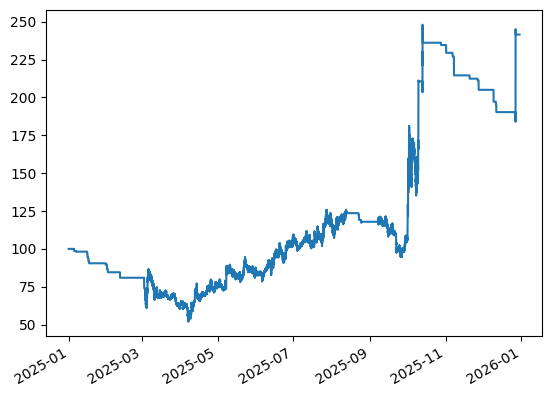

In [213]:
values = pd.Series(values)
values.plot()

In [ ]:
dfa

Open time   Open   High    Low  Close  \
Close time                                                                
2024-12-30 16:59:59.999 2024-12-30 16:55:00  20.23  20.24  20.19  20.24   
2024-12-30 17:04:59.999 2024-12-30 17:00:00  20.25  20.35  20.24  20.27   
2024-12-30 17:09:59.999 2024-12-30 17:05:00  20.26  20.26  20.20  20.21   
2024-12-30 17:14:59.999 2024-12-30 17:10:00  20.21  20.31  20.21  20.25   
2024-12-30 17:19:59.999 2024-12-30 17:15:00  20.25  20.28  20.23  20.25   
...                                     ...    ...    ...    ...    ...   
2025-12-30 16:34:59.999 2025-12-30 16:30:00  12.53  12.54  12.50  12.51   
2025-12-30 16:39:59.999 2025-12-30 16:35:00  12.51  12.52  12.46  12.47   
2025-12-30 16:44:59.999 2025-12-30 16:40:00  12.46  12.47  12.45  12.46   
2025-12-30 16:49:59.999 2025-12-30 16:45:00  12.46  12.47  12.45  12.46   
2025-12-30 16:54:59.999 2025-12-30 16:50:00  12.46  12.46  12.44  12.45   

                           Volume Quote asset volume  Number of trades  \
Close time                                                               
2024-12-30 16:59:59.999   8454.50    170955.36610000               388   
2024-12-30 17:04:59.999  11910.62    241758.64440000               522   
2024-12-30 17:09:59.999  12346.93    249649.97820000               421   
2024-12-30 17:14:59.999  18921.72    383655.83210000               549   
2024-12-30 17:19:59.999   9393.67    190321.42820000               373   
...                           ...                ...               ...   
2025-12-30 16:34:59.999  13625.04    170558.97250000               232   
2025-12-30 16:39:59.999  13653.03    170561.90690000               361   
2025-12-30 16:44:59.999   5989.69     74643.73390000               192   
2025-12-30 16:49:59.999   7236.86     90148.44240000               146   
2025-12-30 16:54:59.999   4981.70     62024.88890000               156   

                         Taker buy base asset volume  \
Close time                                             
2024-12-30 16:59:59.999                      4564.98   
2024-12-30 17:04:59.999                      6458.70   
2024-12-30 17:09:59.999                      3214.69   
2024-12-30 17:14:59.999                     13603.88   
2024-12-30 17:19:59.999                      6407.57   
...                                              ...   
2025-12-30 16:34:59.999                      6247.49   
2025-12-30 16:39:59.999                      1745.08   
2025-12-30 16:44:59.999                      3645.02   
2025-12-30 16:49:59.999                      1133.80   
2025-12-30 16:54:59.999                      4102.25   

                         Taker buy quote asset volume Ignore.  \
Close time                                                      
2024-12-30 16:59:59.999                    92325.5346       0   
2024-12-30 17:04:59.999                   131130.9791       0   
2024-12-30 17:09:59.999                    65006.2379       0   
2024-12-30 17:14:59.999                   275884.9675       0   
2024-12-30 17:19:59.999                   129849.4494       0   
...                                               ...     ...   
2025-12-30 16:34:59.999                    78207.1704       0   
2025-12-30 16:39:59.999                    21809.5689       0   
2025-12-30 16:44:59.999                    45425.2527       0   
2025-12-30 16:49:59.999                    14128.7552       0   
2025-12-30 16:54:59.999                    51075.7830       0   

                         upper_donchian_breach  upper_donchian_breach_score  \
Close time                                                                    
2024-12-30 16:59:59.999                  False                          NaN   
2024-12-30 17:04:59.999                  False                          NaN   
2024-12-30 17:09:59.999                  False                          NaN   
2024-12-30 17:14:59.999                  False                          NaN   
2024-12-30 17:19:59.999                  False

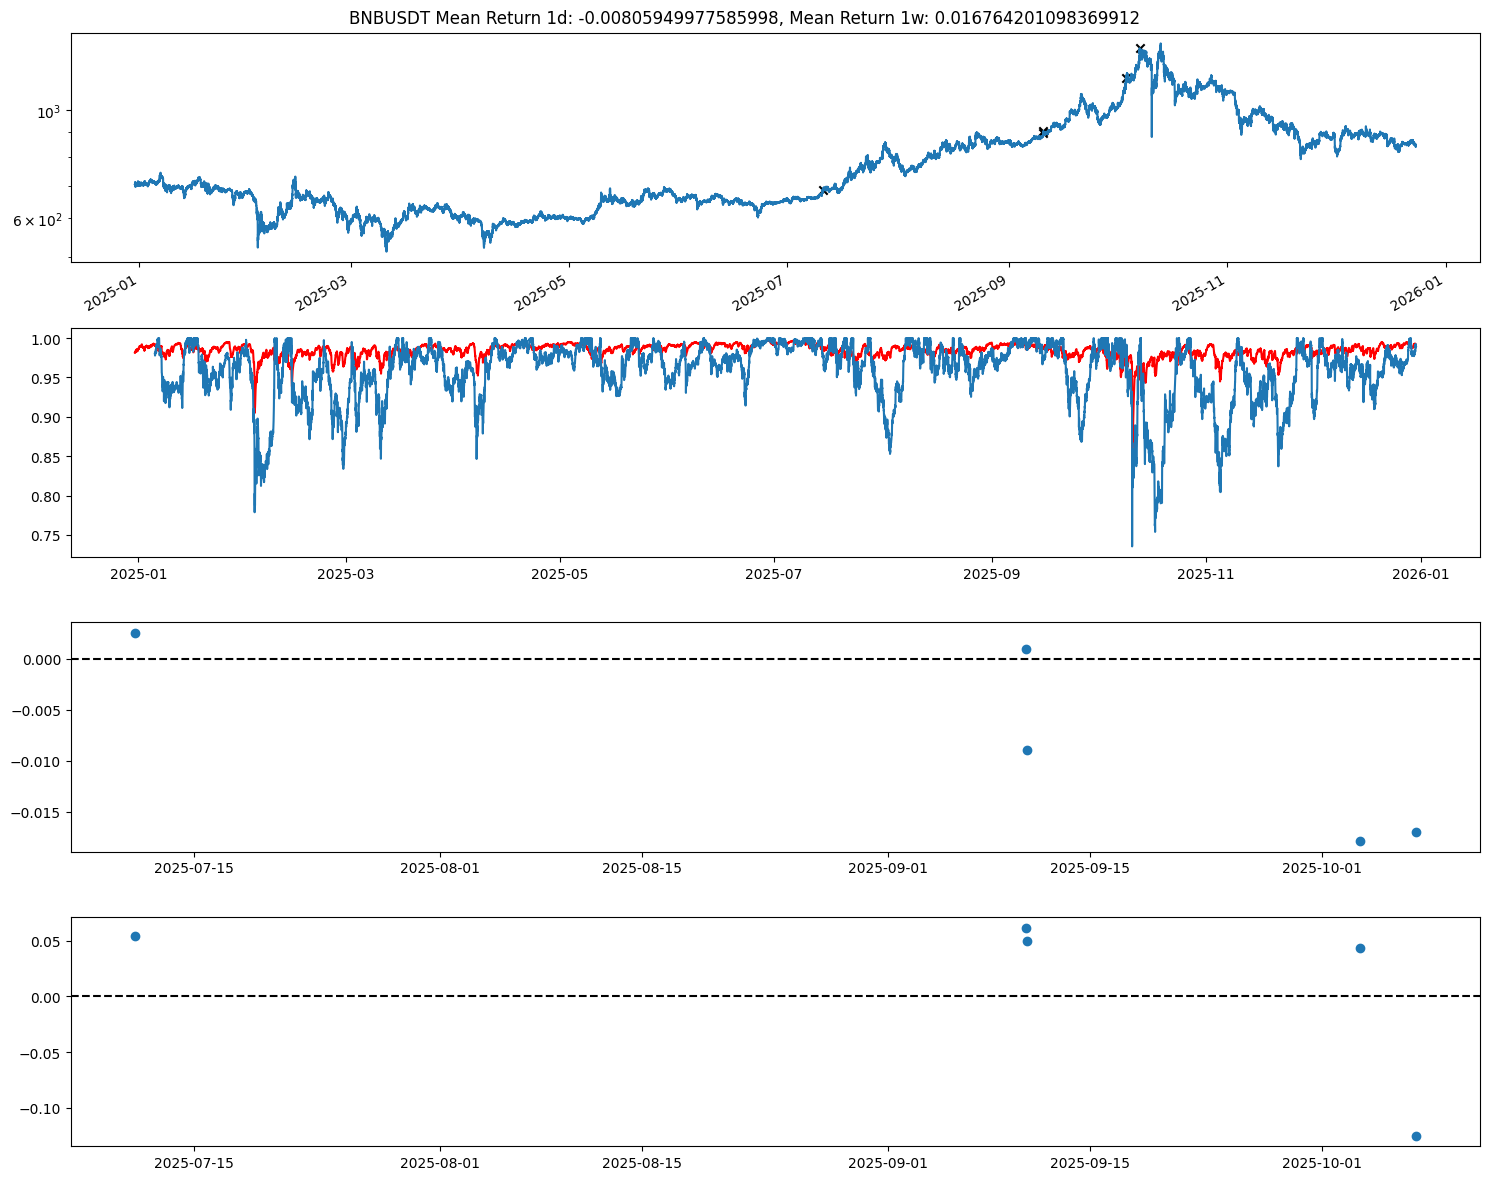

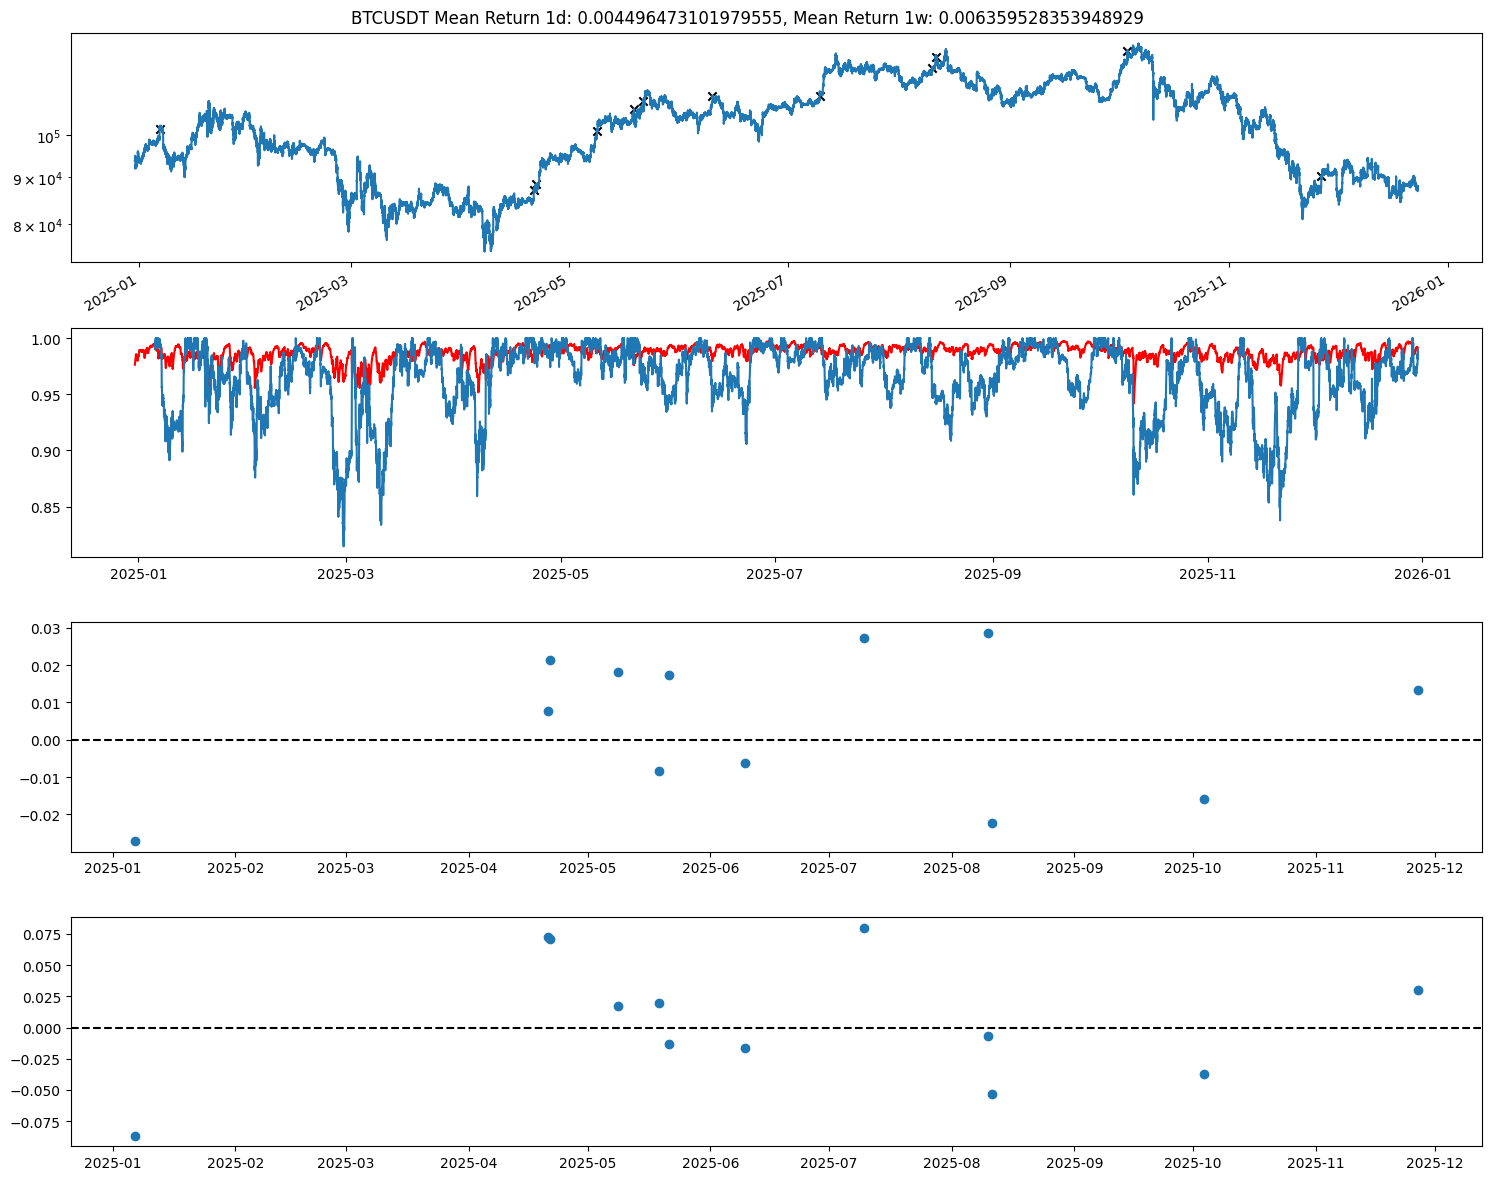

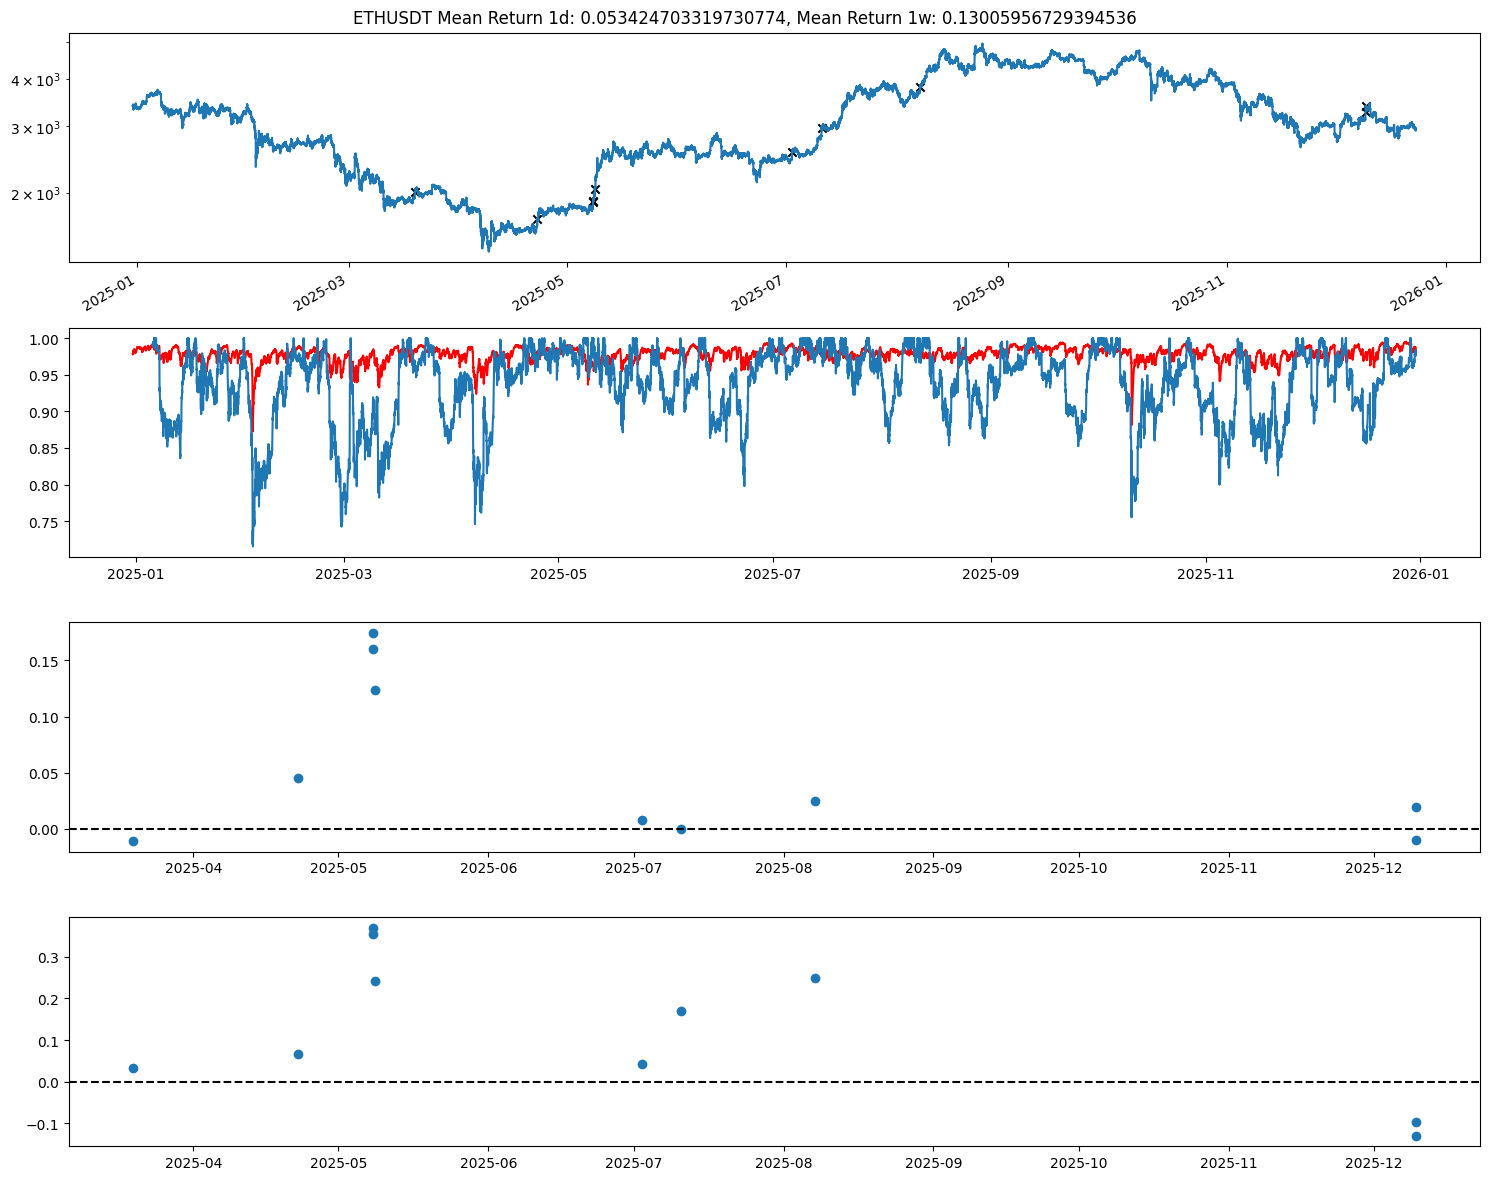

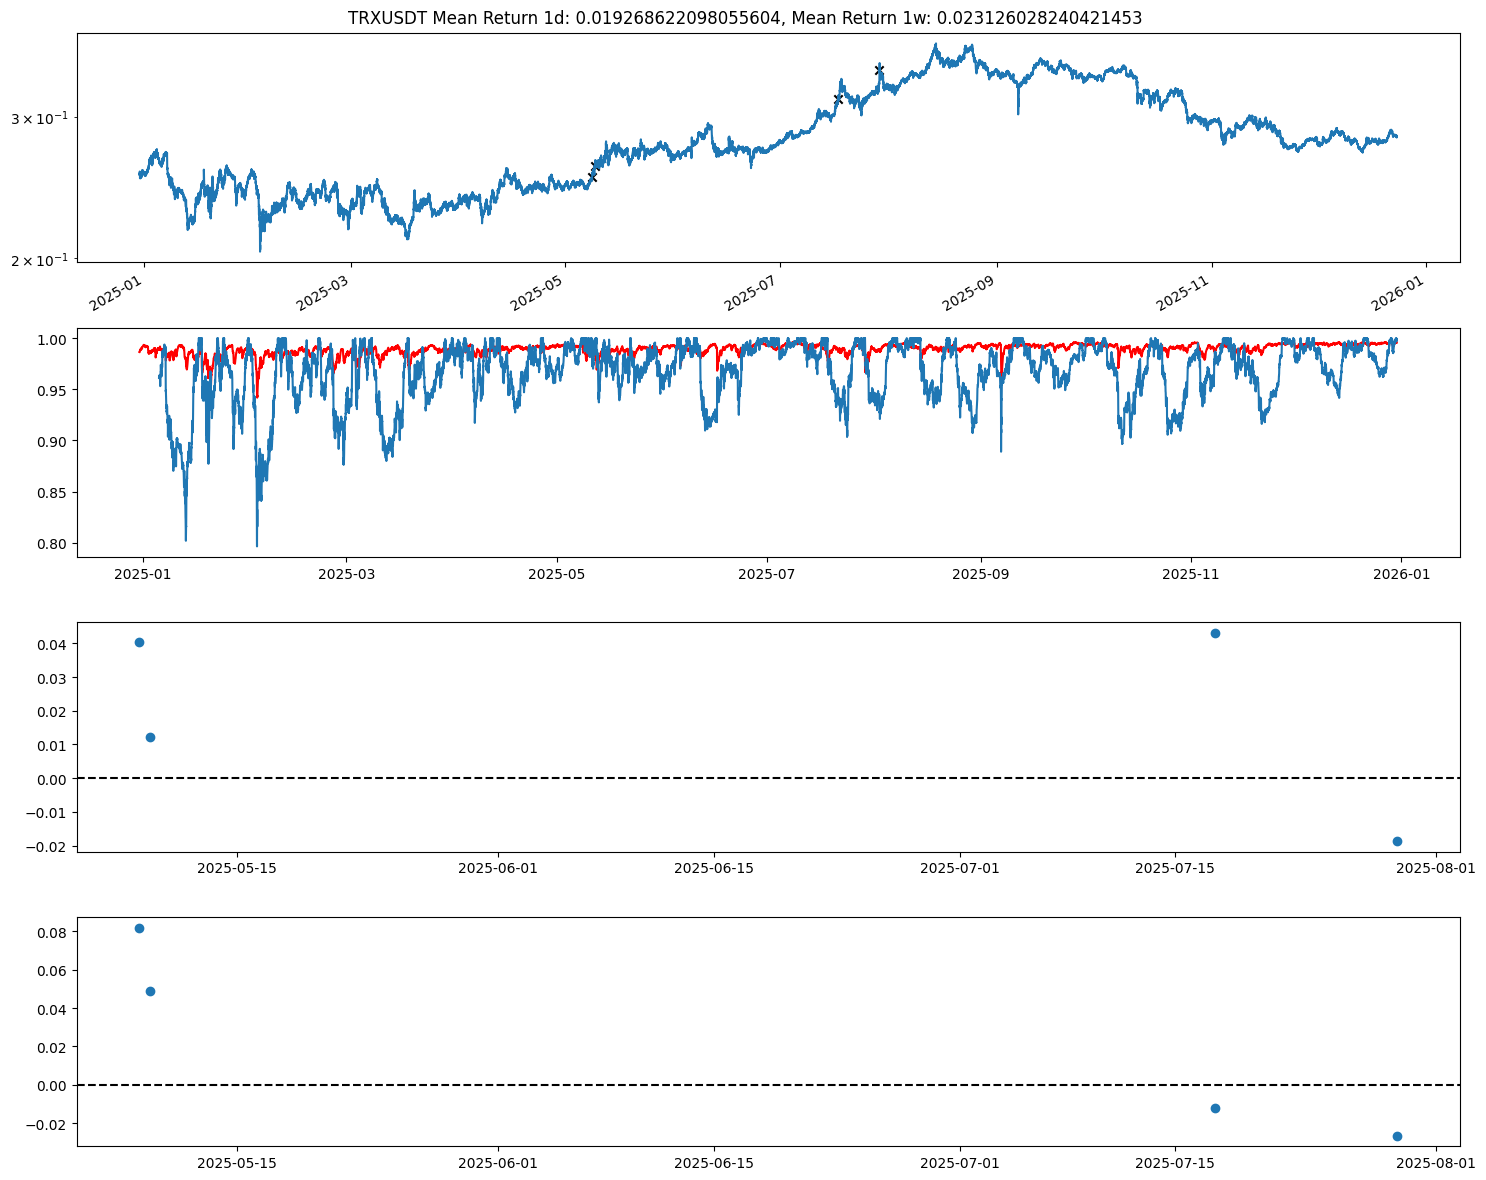

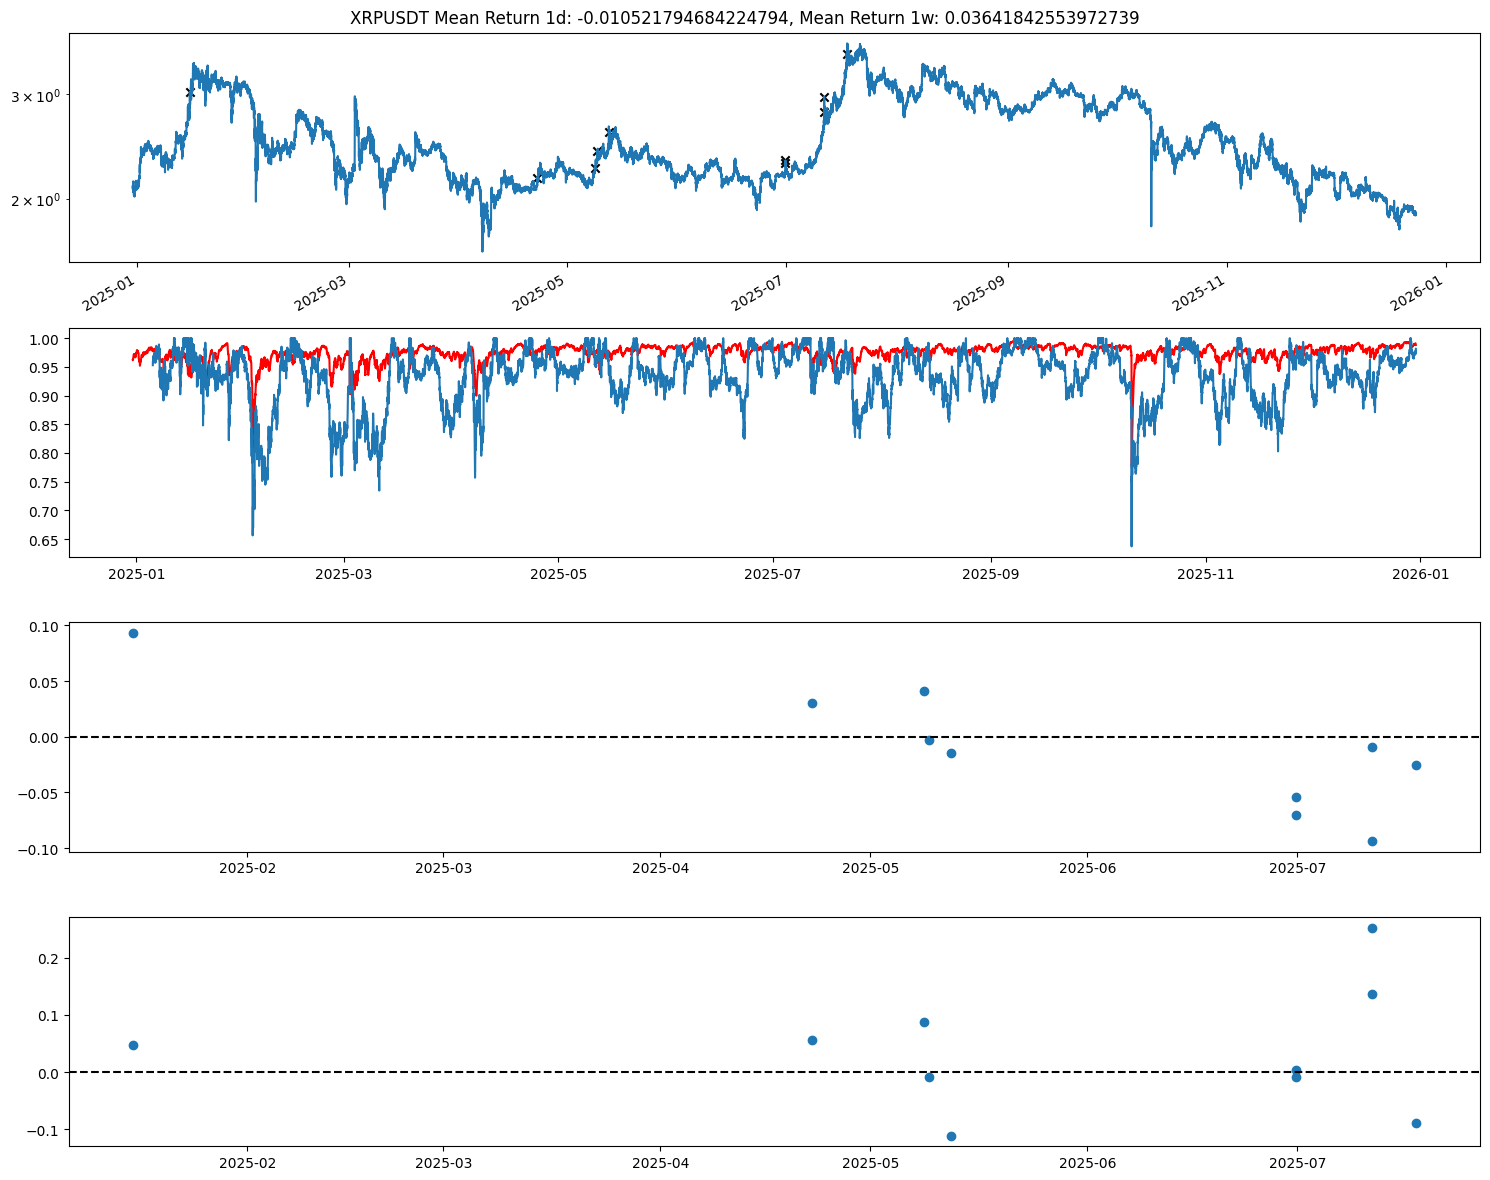

KeyboardInterrupt: 

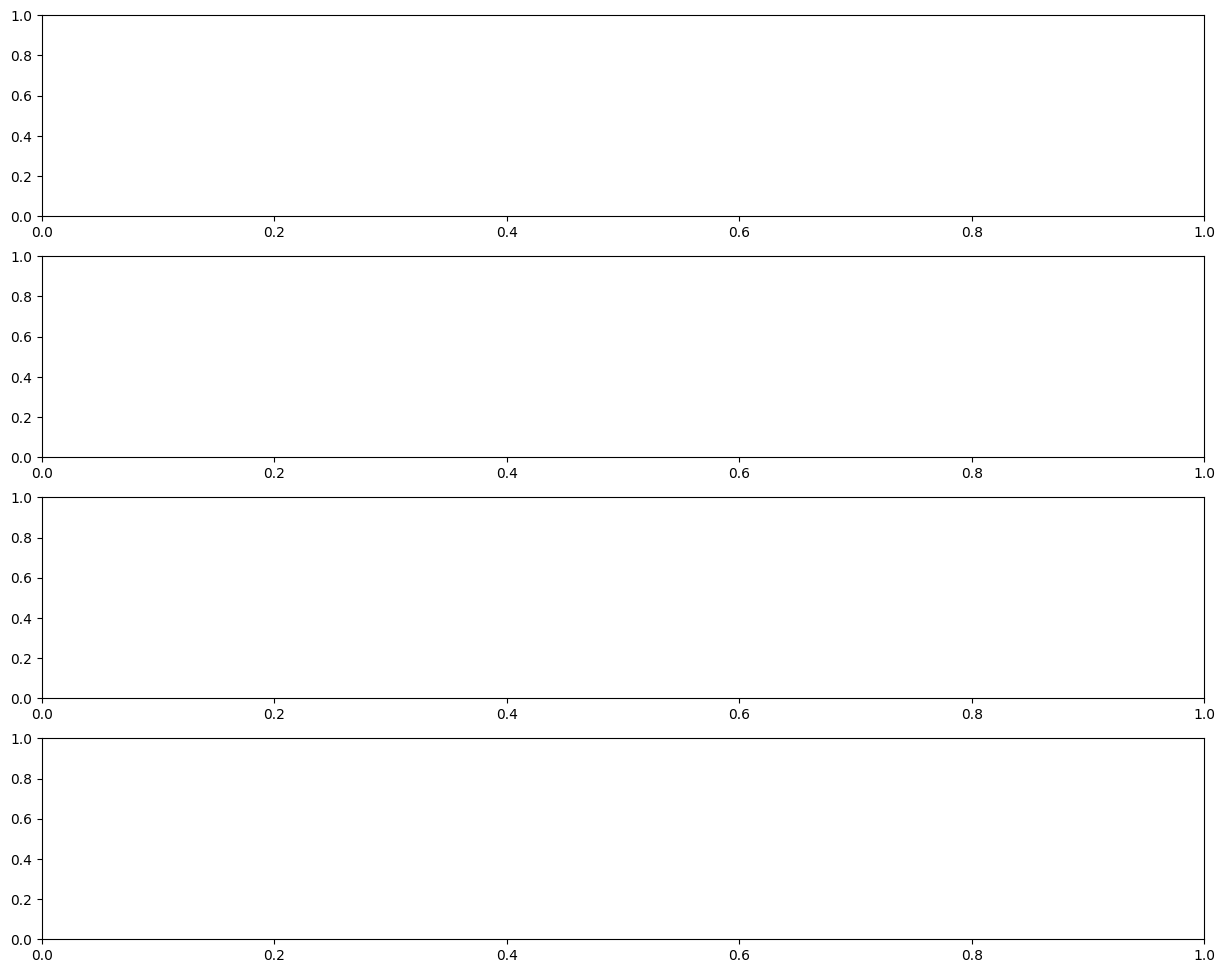

In [ ]:
import talib as ta
import matplotlib.pyplot as plt

stats = {}

for ticker, df in datas_execution.items():

    fig, axs = plt.subplots(4, 1, figsize=(15,12))

    df_signal = datas_signal[ticker]
    df_signal['atr'] = ta.ATR(df_signal['High'], df_signal['Low'], df_signal['Close'], timeperiod=14)
    df_signal['stop_loss'] = df_signal['Close'] - (df_signal['atr'] * config['min_loss_atr'])
    df_signal['relative_stop_loss'] = df_signal['stop_loss'] / df_signal['Close']


    df['ret_fwd_1d'] = df['Close'].pct_change(periods=12*24).shift(-12*24)
    df['ret_fwd_1w'] = df['Close'].pct_change(periods=12*24*7).shift(-12*24*7)

    signal_execution_matches = {}

    signal_names = [filter.NAME for filter in signal_filters]
    execution_names = [filter.NAME for filter in execution_filters]
    last_signal_date = None
    for close_date in df.index[10:-10]:
        signal = df_signal.loc[:close_date, signal_names].iloc[-1]
        atr = df_signal.loc[:close_date, 'atr'].iloc[-1]
        signal_date = signal.name
        if signal.all(): 
            if df.loc[close_date, execution_names].all():
                if signal_date != last_signal_date:
                    signal_execution_matches[close_date] = True
                    last_signal_date = signal_date
                continue
        signal_execution_matches[close_date] = False
        
    df = pd.concat([df, pd.Series(signal_execution_matches, name='signal_execution_matches')], axis=1).dropna()
    atr = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['Close'].plot(ax=axs[0])

    axs[0].scatter(df.loc[df['signal_execution_matches']].index, df.loc[df['signal_execution_matches'], 'Close'], marker='x', label='Buys', color='black')
    axs[0].set_yscale('log')

    axs[1].plot(df_signal['relative_stop_loss'], label='Relative Stop Loss', color='red')
    axs[1].plot(df_signal['Close'] / df_signal['Close'].rolling(window=12*24).max(), label='Close vs 1d High')
    # axs[1].set_yscale('log')

    axs[2].scatter(df.loc[df['signal_execution_matches']].index, df.loc[df['signal_execution_matches'], 'ret_fwd_1d'], label='1d Return')
    axs[2].axhline(0, color='black', linestyle='--')

    axs[3].scatter(df.loc[df['signal_execution_matches']].index, df.loc[df['signal_execution_matches'], 'ret_fwd_1w'], label='1w Return')
    axs[3].axhline(0, color='black', linestyle='--')

    signal_dates_returns_1d = df.loc[df['signal_execution_matches'], 'ret_fwd_1d']
    signal_dates_returns_1w = df.loc[df['signal_execution_matches'], 'ret_fwd_1w']

    stats[ticker] = {
        'mean_return_1d': signal_dates_returns_1d.mean(),
        'median_return_1d': signal_dates_returns_1d.median(),
        'mean_return_1w': signal_dates_returns_1w.mean(),
        'median_return_1w': signal_dates_returns_1w.median(),
        'num_signals': len(signal_dates_returns_1d),
    }

    fig.suptitle(f"{ticker} Mean Return 1d: {stats[ticker]['mean_return_1d']}, Mean Return 1w: {stats[ticker]['mean_return_1w']}")
    fig.tight_layout()

    plt.show()



In [131]:
pd.DataFrame(stats).T.sort_values('mean_return_1w', ascending=False)

mean_return_1d  median_return_1d  mean_return_1w  median_return_1w  \
ZECUSDT         0.017619          0.020134        0.178284          0.119077   
IOTAUSDT        0.014305          0.023795        0.132201          0.179012   
ETHUSDT         0.053425          0.022092        0.130060          0.118102   
DASHUSDT        0.056481          0.017311        0.051026          0.063616   
LINKUSDT        0.013742          0.007759        0.045718          0.040870   
XRPUSDT        -0.010522         -0.011792        0.036418          0.025532   
VETUSDT         0.002229          0.017970        0.026188          0.039342   
TRXUSDT         0.019269          0.026337        0.023126          0.018567   
XLMUSDT        -0.018813         -0.045477        0.020616         -0.018288   
BNBUSDT        -0.008059         -0.008922        0.016764          0.049833   
BTCUSDT         0.004496          0.010623        0.006360          0.005322   
QTUMUSDT        0.020155         -0.014860        0.003641          0.016239   
BCHUSDT        -0.036009          0.001139        0.002375         -0.005500   
ADAUSDT         0.039095          0.019333       -0.005831          0.003354   
BATUSDT         0.005679         -0.004079       -0.016003         -0.026677   
LTCUSDT         0.003240         -0.019343       -0.027598         -0.023280   
ONTUSDT         0.051596          0.016496       -0.038128         -0.011258   
ATOMUSDT       -0.022875         -0.012591       -0.040260         -0.030253   
ETCUSDT         0.005473          0.012893       -0.055528         -0.038732   
NEOUSDT        -0.012393          0.004886       -0.063722         -0.066144   
XTZUSDT        -0.019315         -0.003299       -0.072533         -0.132762   
IOSTUSDT       -0.062869         -0.051001       -0.128830         -0.103037   
USDCUSDT             NaN               NaN             NaN               NaN   

          num_signals  
ZECUSDT           3.0  
IOTAUSDT          3.0  
ETHUSDT          10.0  
DASHUSDT          7.0  
LINKUSDT          6.0  
XRPUSDT          10.0  
VETUSDT           8.0  
TRXUSDT           4.0  
XLMUSDT           7.0  
BNBUSDT           5.0  
BTCUSDT          12.0  
QTUMUSDT          5.0  
BCHUSDT           5.0  
ADAUSDT           8.0  
BATUSDT          11.0  
LTCUSDT          10.0  
ONTUSDT           5.0  
ATOMUSDT          8.0  
ETCUSDT           7.0  
NEOUSDT           5.0  
XTZUSDT           9.0  
IOSTUSDT         10.0  
USDCUSDT          0.0

In [133]:
pd.DataFrame(stats).T.mean()

mean_return_1d      0.005270
median_return_1d    0.001337
mean_return_1w      0.010198
median_return_1w    0.010133
num_signals         6.869565
dtype: float64